In [445]:
import mdtraj

ref_fname = 'alanine-dipeptide-nowater.pdb'
traj_fname = 'alanine-dipeptide-0-250ns-nowater.xtc'

ref = mdtraj.load(ref_fname)
traj = mdtraj.load_xtc(traj_fname, top=ref.topology)
# traj = traj[::25]
# traj.save('training_traj.xtc')

In [446]:
traj[:1000].save('first_100_frames.pdb')

In [447]:
traj.xyz.shape

(250000, 22, 3)

In [448]:
#clusters = [[0,1,2,3,4,5],[6,7,8,9,10,11,12,13,14,15],[16,17,18,19,20,21]]
clusters = [[4],[6],[8],[14],[16]]

# we use geometric average
proposal_cg_traj = np.concatenate(tuple([np.mean(traj.xyz[:, cluster, :], axis=1)[:, None, :] \
                                            for cluster in clusters]), axis=1)
proposal_cg_traj.shape

(250000, 5, 3)

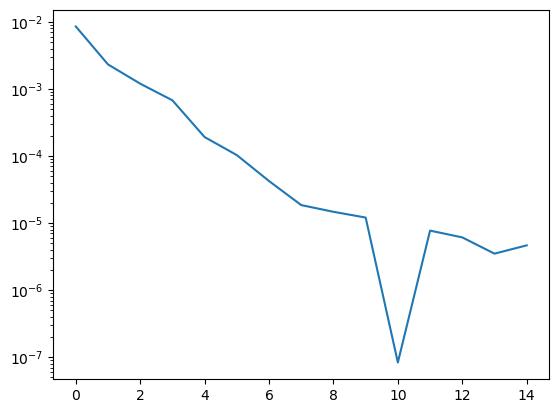

In [456]:
from itertools import product
n_particles=5
# K_total = np.zeros((n_particles, n_particles))

# n_batch = 250000
n_keep = 9
n_datapoints = 250000
data = proposal_cg_traj[:n_datapoints, :, :].reshape((-1, n_particles*3))
C = np.cov(data, rowvar=False)
evals, evecs = np.linalg.eig(C)

plt.semilogy(evals)

evals = evals[:n_keep]
evecs = evecs[:n_keep, :] #discard 6 dof

K = np.zeros((n_particles, n_particles))
for i, j in product(range(n_particles), range(n_particles)):
    K[i, j] = np.sum(np.dot(evecs[:, i], evecs[:, j]/evals))

for i in range(n_particles):
    #K[i, i] = -np.sum(K[i, :i]) - np.sum(K[i, i+1:])
    K[i,i]=0
# K_total += K
# K_total /= len(proposal_cg_traj)//n_batch

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


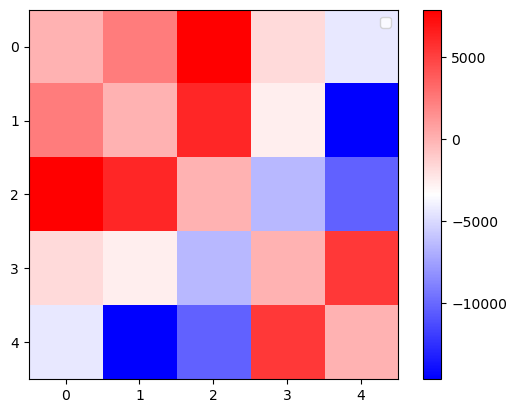

In [457]:
plt.imshow(K, cmap='bwr', interpolation='nearest')
plt.legend()
plt.colorbar()
plt.show()

In [444]:
K

array([[  0.        , -11.59390954,  -5.97159294],
       [-11.59390954,   0.        ,   3.83207258],
       [ -5.97159294,   3.83207258,   0.        ]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


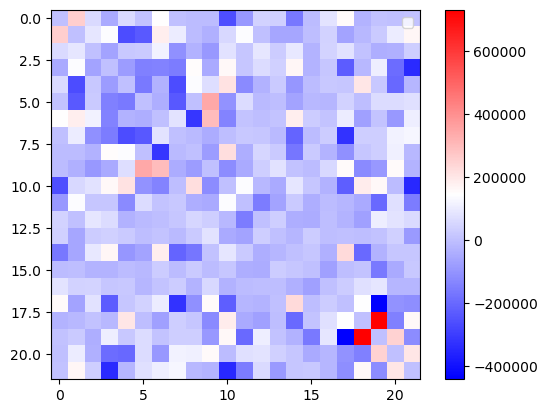

In [363]:
plt.imshow(K_total, cmap='bwr', interpolation='nearest')
plt.legend()
plt.colorbar()
plt.show()

In [244]:
K

array([[    0.        ,  3399.99277548,  2087.93409915],
       [ 3399.99277548,     0.        , -3661.13920051],
       [ 2087.93409915, -3661.13920051,     0.        ]])

In [240]:
K

array([[    0.        ,  3355.56065568,  2263.44412098],
       [ 3355.56065568,     0.        , -3672.66898959],
       [ 2263.44412098, -3672.66898959,     0.        ]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


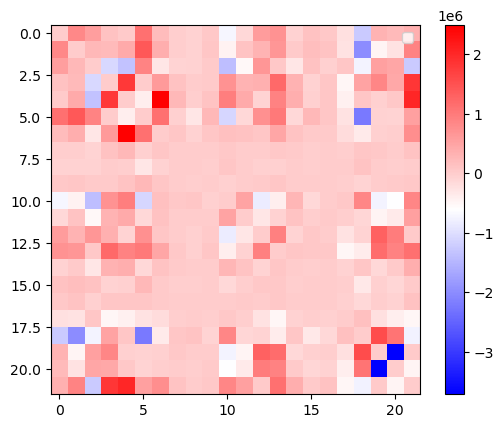

In [232]:
import matplotlib.pyplot as plt

plt.imshow(K, cmap='bwr', interpolation='nearest')
plt.legend()
plt.colorbar()
plt.show()


In [224]:
dist = mdtraj.compute_distances(traj, product(range(n_particles), range(n_particles)))
dist_map = np.mean(dist, axis=0).reshape(n_particles, n_particles)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


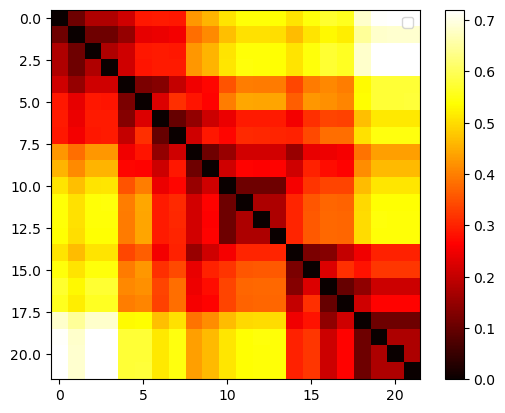

In [225]:
plt.imshow(dist, cmap='hot', interpolation='nearest')
plt.legend()
plt.colorbar()
plt.show()

In [152]:
cluster1 = proposal_cg_traj
cluster1.shape

(10000, 3, 3)

In [77]:
import numpy as np
import torch
from tqdm import tqdm

# courtesy of minhuan's code
def decom_inverse(G):
    eigvalues, eigvectors = np.linalg.eig(G)
    w = np.argsort(eigvalues)[::-1][:np.linalg.matrix_rank(G)]
    res = np.zeros(G.shape)
    for j in w:
        res += (1/eigvalues[j])*eigvectors[:,j].reshape(-1,1)@eigvectors[:,j].reshape(1,-1)
    return res

def NLL_gamma(data,mu,gamma,rank):
    real_eigenval = torch.abs(torch.linalg.eig(gamma)[0])
    reverse_det = 1./torch.sort(real_eigenval, descending=True)[0][:rank]
    return 0.5*torch.sum(torch.log(reverse_det)) + 0.5*torch.trace(torch.mm(torch.mm(data-mu,gamma),(data-mu).T))/len(data)

def kronecker(A, B):
    return torch.einsum("ab,cd->acbd", A, B).view(A.size(0)*B.size(0),  A.size(1)*B.size(1))

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
n_coords = 3

# initialize the parameters
centroid = np.mean(cluster1,axis=0)
Cov_xx = np.cov(cluster1[:,:,0],rowvar=False)
Cov_yy = np.cov(cluster1[:,:,1],rowvar=False)
Cov_zz = np.cov(cluster1[:,:,2],rowvar=False)
gamma_0 = (decom_inverse(Cov_xx)+decom_inverse(Cov_yy)+decom_inverse(Cov_zz))/3.
L_0 = np.tril(gamma_0,k=-1) 
mask = np.tril(np.full((n_coords, n_coords),1),k=-1)
fixed = np.zeros((n_coords, n_coords))

## Tensorize 
LT = torch.tensor(L_0,dtype=torch.float64, requires_grad=True)
mu = torch.tensor(centroid.reshape(-1),dtype=torch.float64,device=device, requires_grad=True)
mask_ts = torch.tensor(mask, dtype=torch.float64, requires_grad=False)
fixed_ts = torch.tensor(fixed, dtype=torch.float64, requires_grad=False)
I3 = torch.eye(3,dtype=torch.float64, requires_grad=False)
data_tensor = torch.tensor(cluster1.reshape(-1,n_coords*3),dtype=torch.float64)

# Optimize
mu_log=[]
gamma_log=[]
loss_log=[]
n_epoch=2000
batch_size=500
batches = int(len(data_tensor) / batch_size)
optimizer = torch.optim.Adam([mu,LT],lr=0.01)

for epoch in tqdm(range(n_epoch)):    
    indices = np.arange(len(data_tensor))
    np.random.shuffle(indices)
    
    for i in range(batches):
        
        if i == batches - 1:
            batch_indices = indices[i * batch_size:]
        else:
            batch_indices = indices[i * batch_size:(i + 1) * batch_size]
        
        optimizer.zero_grad()
        print(LT)
        L = -torch.exp(LT)*mask_ts + (1-mask_ts)*fixed_ts
        gamma = kronecker(L + L.T - (L + L.T).sum(1).diag(), I3)
        loss = NLL_gamma(data_tensor[batch_indices],mu,gamma, (n_coords-1)*3)
        mu_log.append(mu.detach().numpy().copy())
        gamma_log.append(gamma.detach().numpy().copy())
        loss_log.append(loss.detach().numpy().copy())
          
        loss.backward()
        optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

tensor([[   0.0000,    0.0000,    0.0000],
        [ 412.1073,    0.0000,    0.0000],
        [-316.4123,  741.5592,    0.0000]], dtype=torch.float64,
       requires_grad=True)


RuntimeError: torch.linalg.eig: input tensor should not contain infs or NaNs.

In [ ]:
Gamma = gamma_log[-1]
gamma = Gamma[::3, ::3]
gamma

array([[ -370.041529  ,   879.26060241,  -509.21907341],
       [  879.26060241, -2088.06573976,  1208.80513735],
       [ -509.21907341,  1208.80513735,  -699.58606394]])

In [ ]:
gamma_0

array([[1609.7409617 ,  412.10734229, -316.4123372 ],
       [ 412.10734229, 3420.92439329,  741.55924185],
       [-316.4123372 ,  741.55924185,  859.11516235]])

In [ ]:
decom_inverse(Cov_zz)

array([[1404.36725245,  844.46512677, -514.8335537 ],
       [ 844.46512677, 1138.22843527, -532.26627621],
       [-514.8335537 , -532.26627621,  446.80943048]])

In [ ]:
fixed_ts

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)

In [122]:
gamma_star_opt_collection = {}

In [154]:
rank = 4
Cov_xx = np.cov(cluster1[:,:,0],rowvar=False)
Cov_yy = np.cov(cluster1[:,:,1],rowvar=False)
Cov_zz = np.cov(cluster1[:,:,2],rowvar=False)
gamma_0 = (decom_inverse(Cov_xx)+decom_inverse(Cov_yy)+decom_inverse(Cov_zz))/3.
L_0 = np.tril(gamma_0,k=-1)

# make all positive elements in L_0 to -1e-5 (only keep negative elements), then log(-*), for a new parameterization initialization
L0_negative = L_0.copy()
L0_negative[L0_negative>0] = -1e-5
L0_Nlg = L0_negative.copy()
L0_Nlg[L0_Nlg < 0] = np.log(-L0_Nlg[L0_Nlg < 0])

mask = np.tril(np.full((n_coords,n_coords),1),k=-1)
fixed = np.zeros((n_coords,n_coords))

LT_Nlg = torch.tensor(L0_Nlg,dtype=torch.float64, requires_grad=True)
mu = torch.tensor(centroid.reshape(-1),dtype=torch.float64,requires_grad=True)
mask_ts = torch.tensor(mask, dtype=torch.float64, requires_grad=False)
fixed_ts = torch.tensor(fixed, dtype=torch.float64, requires_grad=False)
I3 = torch.eye(3,dtype=torch.float64, requires_grad=False)
data_tensor = torch.tensor(cluster1.reshape(-1,n_coords*3),dtype=torch.float64)


optimizer = torch.optim.Adam([mu,LT_Nlg],lr=1e-3)

mu_log=[]
gamma_log=[]
loss_log=[]
n_epoch=3000
batch_size=500
batches = int(len(data_tensor) / batch_size)
step_count = 0.
for epoch in tqdm(range(n_epoch)):
    indices = np.arange(len(data_tensor))
    np.random.shuffle(indices)
    
    for i in range(batches):
        
        if i == batches - 1:
            batch_indices = indices[i * batch_size:]
        else:
            batch_indices = indices[i * batch_size:(i + 1) * batch_size]
        
        optimizer.zero_grad()
        LT = -torch.exp(LT_Nlg)
        L = LT*mask_ts + (1-mask_ts)*fixed_ts
        gamma = kronecker(L + L.T - (L + L.T).sum(1).diag(), I3)
        loss = NLL_gamma(data_tensor[batch_indices],mu,gamma, rank)
        mu_log.append(mu.detach().numpy().copy())
        if step_count % 100 == 0:
            gamma_log.append(gamma.detach().numpy().copy())
        loss_log.append(loss.detach().numpy().copy())
          
        loss.backward()
        optimizer.step()
        
        step_count += 1


mu_opt = mu.detach().numpy().copy()
L_opt = L.detach().numpy().copy()
gamma_star = L + L.T - (L + L.T).sum(1).diag()
gamm_star_opt = gamma_star.detach().numpy().copy()
# np.save(r'Model_Inference_Result/mu_opt.npy',mu_opt)
# np.save(r'Model_Inference_Result/L_opt.npy',L_opt)
# np.save(r'Model_Inference_Result/gamma_star_opt.npy',gamm_star_opt)
gamma_star_opt_collection[rank] = gamm_star_opt

100%|██████████| 3000/3000 [01:49<00:00, 27.32it/s]


In [116]:
gamm_star_opt # rank=1

array([[ 8.04735038e+01, -4.68464030e-09, -8.04735038e+01],
       [-4.68464030e-09,  1.04006950e-08, -5.71605471e-09],
       [-8.04735038e+01, -5.71605471e-09,  8.04735038e+01]])

In [118]:
gamm_star_opt #rank=2

array([[ 1.64536820e+02, -4.67458193e-09, -1.64536820e+02],
       [-4.67458193e-09,  1.03787844e-08, -5.70420251e-09],
       [-1.64536820e+02, -5.70420251e-09,  1.64536820e+02]])

In [123]:
gamm_star_opt #rank=3

array([[ 2.43104751e+02, -4.66847402e-09, -2.43104751e+02],
       [-4.66847402e-09,  1.03645760e-08, -5.69610194e-09],
       [-2.43104751e+02, -5.69610194e-09,  2.43104751e+02]])

In [130]:
gamm_star_opt # rank=4

array([[ 2.14677938e+02, -1.75653415e-07, -2.14677937e+02],
       [-1.75653415e-07,  1.02142458e+02, -1.02142457e+02],
       [-2.14677937e+02, -1.02142457e+02,  3.16820395e+02]])

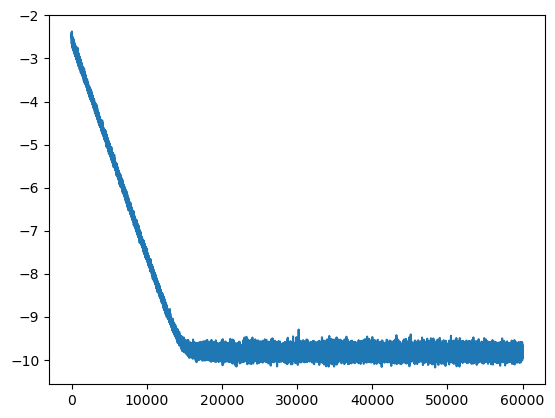

In [156]:
plt.plot(loss_log)

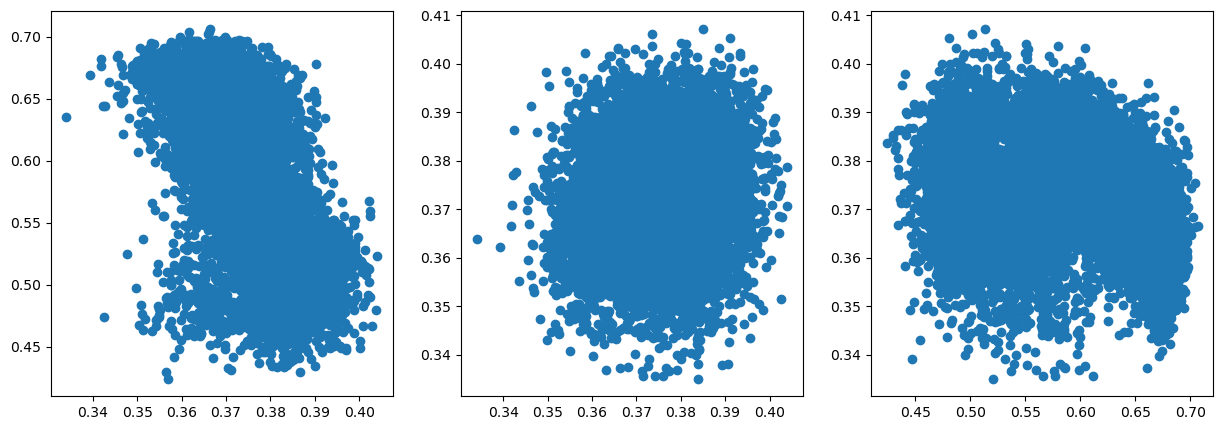

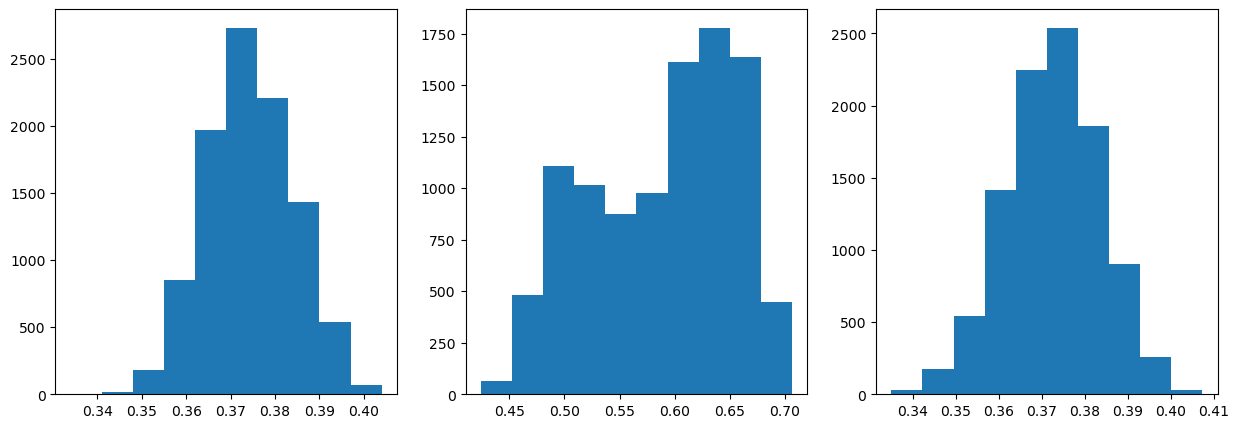

In [144]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig2, axes2 = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))


d01 = np.linalg.norm(proposal_cg_traj[:,0,:]-proposal_cg_traj[:,1,:], axis=1)
d02 = np.linalg.norm(proposal_cg_traj[:,0,:]-proposal_cg_traj[:,2,:], axis=1)
d12 = np.linalg.norm(proposal_cg_traj[:,1,:]-proposal_cg_traj[:,2,:], axis=1)

axes[0].scatter(d01, d02)
axes[1].scatter(d01, d12)
axes[2].scatter(d02, d12)

axes2[0].hist(d01)
axes2[1].hist(d02)
_=axes2[2].hist(d12)


In [145]:
gamm_star_opt

array([[ 2.14677938e+02, -1.75653415e-07, -2.14677937e+02],
       [-1.75653415e-07,  1.02142458e+02, -1.02142457e+02],
       [-2.14677937e+02, -1.02142457e+02,  3.16820395e+02]])

In [155]:
gamm_star_opt

array([[ 1.86022588e+02, -2.80076442e-06, -1.86022585e+02],
       [-2.80076442e-06,  1.39783094e+02, -1.39783091e+02],
       [-1.86022585e+02, -1.39783091e+02,  3.25805677e+02]])

In [ ]:
C12 = np.cov(cluster1[:,:,0],rowvar=False)